## **USA Real Estate: Analysis and Prediction House Price in US** 

📌 The real estate market in the United States is a complex, data-rich environment shaped by a wide range of factors — from the physical characteristics of a property to its geographic location and surrounding socio-economic conditions. Understanding how these factors influence housing prices is essential for a variety of stakeholders, including homebuyers, investors, developers, and financial institutions. 

📌 In this notebook, we will focus to answer the following questions:
 * **What is the overall picture of the USA housing prices w.r.t. locations?**

 * **Do house attributes (bedroom, bathroom count) strongly correlate with the price? Are there any hidden patterns?**

 * **How are housing price and location attributes correlated?**

 * **Can we predict housing prices based on the features?**

📌 Aim of the Project:

We analyze housing data across the United States in order to understand the key factors that influence home prices, and to develop machine learning models capable of predicting property values based on physical characteristics and location.

✅ Helps buyers and sellers make informed decisions on pricing.

✅ Supports investors in identifying undervalued or overvalued markets.

✅ Serves as a foundation for automated real estate valuation systems.

📌 To address those questions above, the notebook includes sections:

**1. Data Processing with PySpark**

**2. Exploratory Data Analysis**

**3. Predictive Modeling**

# 1. Data Processing with PySpark

📌 About the Dataset: 

The dataset contains Real Estate listings in the US broken by State and zip code that was collected from https://www.realtor.com/ - the second most visited real estate listing website in the United States as of 2024, with over 100 million monthly active users.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DoubleType, LongType, DateType, TimestampType
from pyspark.sql.functions import col, expr, when, count, sum, min, max, round, desc, avg, lit, stddev, mean ,lag
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**1.1. Data Collection**

In [3]:
spark = SparkSession.builder.appName("RealtorDataAnalysis").getOrCreate()

In [ ]:
df = spark.read.csv("realtor-data.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)

root
 |-- brokered_by: double (nullable = true)
 |-- status: string (nullable = true)
 |-- price: double (nullable = true)
 |-- bed: integer (nullable = true)
 |-- bath: integer (nullable = true)
 |-- acre_lot: double (nullable = true)
 |-- street: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip_code: integer (nullable = true)
 |-- house_size: double (nullable = true)
 |-- prev_sold_date: date (nullable = true)

+-----------+--------+--------+---+----+--------+---------+----------+-----------+--------+----------+--------------+
|brokered_by|  status|   price|bed|bath|acre_lot|   street|      city|      state|zip_code|house_size|prev_sold_date|
+-----------+--------+--------+---+----+--------+---------+----------+-----------+--------+----------+--------------+
|   103378.0|for_sale|105000.0|  3|   2|    0.12|1962661.0|  Adjuntas|Puerto Rico|     601|     920.0|          NULL|
|    52707.0|for_sale| 80000.0|  4|   2|    0.08|1902

**1.2. Data Cleaning**

In [5]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

df = df.withColumn("brokered_by", col("brokered_by").cast(StringType()))
df = df.withColumn("street", col("street").cast(StringType()))
df = df.withColumn("zip_code", col("zip_code").cast(StringType()))

In [6]:
from pyspark.sql import Row

total_rows = df.count()

null_counts = df.select([
    (count(when(col(c).isNull(), c)).alias(c)) for c in df.columns
]).collect()[0].asDict()

null_percentage_rows = [
    Row(column_name=col_name, null_pct=null_count / total_rows * 100)
    for col_name, null_count in null_counts.items()
]

pivoted_df = spark.createDataFrame(null_percentage_rows)

# Show the result
pivoted_df.show()

+--------------+--------------------+
|   column_name|            null_pct|
+--------------+--------------------+
|   brokered_by| 0.20360387390843082|
|        status|                 0.0|
|         price| 0.06921543562605159|
|           bed|  21.618796774318152|
|          bath|  22.986666259428976|
|      acre_lot|  14.624130090882876|
|        street| 0.48805640721134114|
|          city| 0.06319670209335146|
|         state|3.593273750865754...|
|      zip_code|0.013429860643860756|
|    house_size|  25.533982937339594|
|prev_sold_date|   32.98162669299339|
+--------------+--------------------+



Almost all columns get null value. The column gets highest null percentage is prev_sold_date (around 33%).
Suggested ways to deal with null value:

1. Drop NaN for columns that has null > 5%

2. If 0% <= null percentage <= 5% and variable is numeric then fill null value with mean value

3. If 0% <= null percentage <= 5% and variable is categorical then fill null value with mode value

4. Remove columns with highest null value & insignificant to the objective of this topic which is prev_sold_date

In [7]:
from pyspark.sql import functions as F

drop_nan = ["bed","bath","acre_lot","house_size"]
remove_cols = ["prev_sold_date"]
numeric_cols = ["price"]
cat_cols = ["brokered_by","status","city","state", "zip_code", "street"]

# drop columns
df_cleaned = df.drop(*remove_cols)

# drop NaN
df_cleaned = df_cleaned.dropna(subset=drop_nan)
# Compute mean for numeric variables
means = {}
mean_values = df_cleaned.select([F.mean(c).alias(c) for c in numeric_cols]).collect()[0]
for c in numeric_cols:
    mean_val = mean_values[c]
    if mean_val is not None:
        means[c] = mean_val

# Compute modes for categorical columns
modes = {}
for c in cat_cols:
    mode_val = df_cleaned.groupBy(c).count().orderBy(F.desc("count")).first()
    if mode_val:
        modes[c] = mode_val[c]
    else:
        modes[c] = 'Unknown'

modes = {k: v if v is not None else 'Unknown' for k, v in modes.items()}

# Fill missing numeric values with mean
df_filled = df_cleaned.fillna(means)

# Fill missing categorical values with mode
valid_modes = {col: modes[col] for col in modes if col in df_cleaned.columns}
df_filled = df_filled.fillna(valid_modes)

df_filled.show()

+-----------+--------+--------+---+----+--------+---------+-------------+-----------+--------+----------+
|brokered_by|  status|   price|bed|bath|acre_lot|   street|         city|      state|zip_code|house_size|
+-----------+--------+--------+---+----+--------+---------+-------------+-----------+--------+----------+
|   103378.0|for_sale|105000.0|  3|   2|    0.12|1962661.0|     Adjuntas|Puerto Rico|     601|     920.0|
|    52707.0|for_sale| 80000.0|  4|   2|    0.08|1902874.0|     Adjuntas|Puerto Rico|     601|    1527.0|
|   103379.0|for_sale| 67000.0|  2|   1|    0.15|1404990.0|   Juana Diaz|Puerto Rico|     795|     748.0|
|    31239.0|for_sale|145000.0|  4|   2|     0.1|1947675.0|        Ponce|Puerto Rico|     731|    1800.0|
|   103378.0|for_sale|179000.0|  4|   3|    0.46|1850806.0|San Sebastian|Puerto Rico|     612|    2520.0|
|     1205.0|for_sale| 50000.0|  3|   1|     0.2|1298094.0|       Ciales|Puerto Rico|     639|    2040.0|
|    50739.0|for_sale| 71600.0|  3|   2|    0.

In [8]:
from pyspark.sql.functions import col, sum
null_counts = df_filled.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_filled.columns])
null_counts.show()

+-----------+------+-----+---+----+--------+------+----+-----+--------+----------+
|brokered_by|status|price|bed|bath|acre_lot|street|city|state|zip_code|house_size|
+-----------+------+-----+---+----+--------+------+----+-----+--------+----------+
|          0|     0|    0|  0|   0|       0|     0|   0|    0|       0|         0|
+-----------+------+-----+---+----+--------+------+----+-----+--------+----------+



Finish dealing with null values

In [9]:
num_rows = df_filled.count()
num_columns = len(df_filled.columns)

print(f"Rows: {num_rows}, Columns: {num_columns}")

Rows: 1361241, Columns: 11


**1.3. Remove outliers**

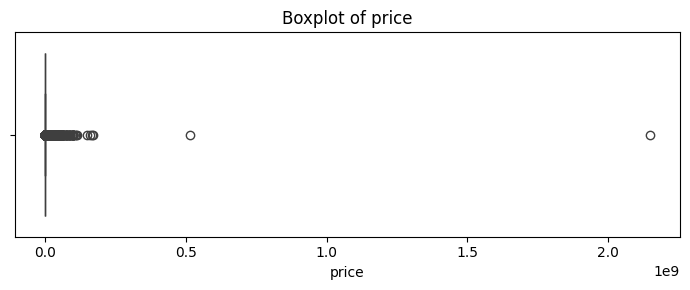

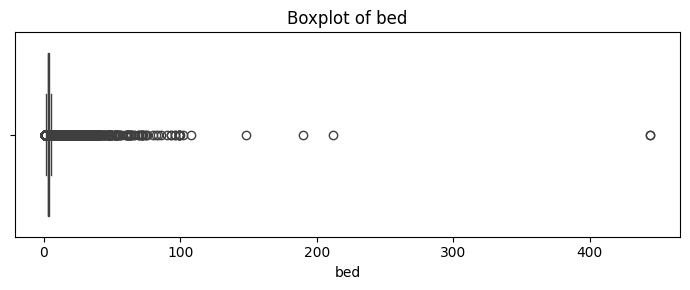

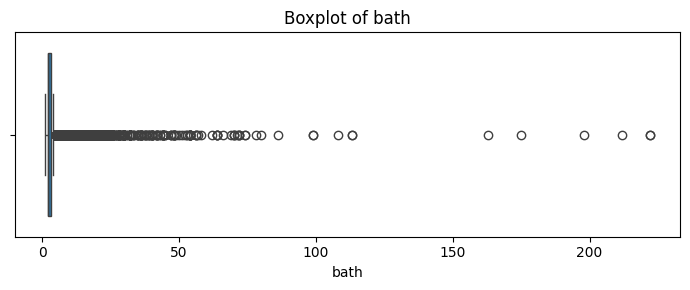

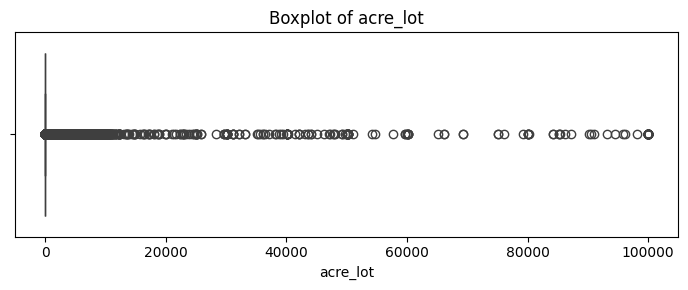

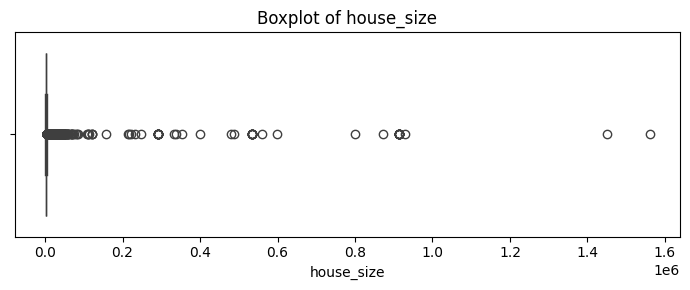

In [10]:
# Boxplot of numeric values
numeric_cols = ["price", "bed", "bath", "acre_lot", "house_size"]
df_filled_pd = df_filled.select(numeric_cols).toPandas()

for col_name in numeric_cols:
    plt.figure(figsize=(7, 3))
    sns.boxplot(x=df_filled_pd[col_name].dropna())
    plt.title(f'Boxplot of {col_name}')
    plt.xlabel(col_name)
    plt.tight_layout()
    plt.show()

Most numerical features contain numerous extreme outliers, causing the distributions to be heavily skewed. Therefore, handling outliers is essential before conducting any statistical analysis or training predictive models, in order to minimize noise and improve the reliability of the results.

In [11]:
from pyspark.sql.functions import col

def remove_outliers(df, column):
    q1, q3 = df.approxQuantile(column, [0.25, 0.75], 0.05)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    return df.filter((col(column) >= lower) & (col(column) <= upper))

# Apply removal to each column
df_process = df_filled
outlier_cols = ["price", "bed", "bath", "acre_lot", "house_size"]
for c in outlier_cols:
    df_process = remove_outliers(df_process, c)

Finish dealing with outliers by removing outliers by lower and upper bound

After processing data, the distribution of numeric variables look likes:

In [12]:
df_process_pd = df_process.toPandas()

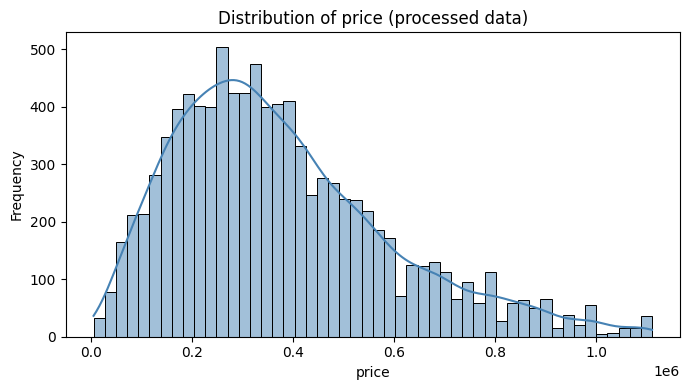

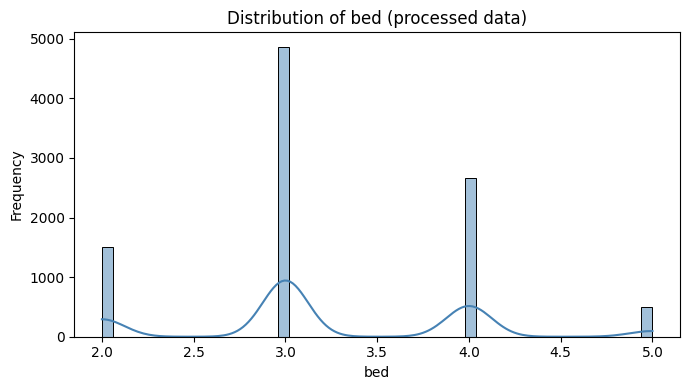

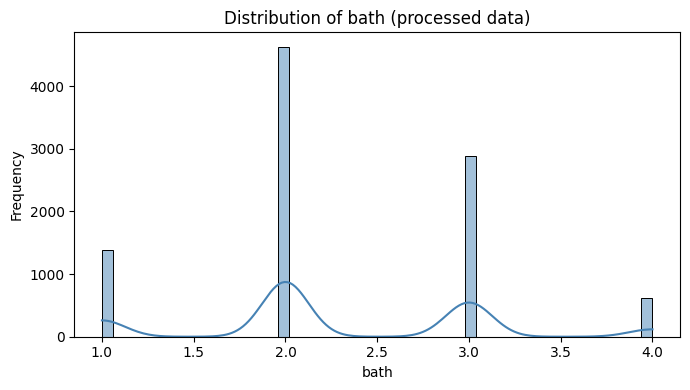

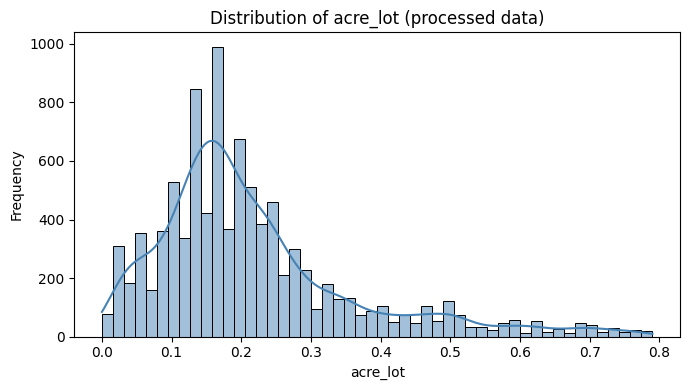

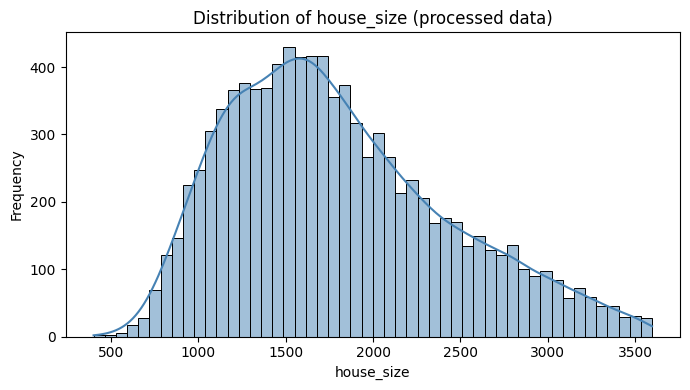

In [13]:
numeric_cols = ['price', 'bed', 'bath', 'acre_lot', 'house_size']
df_numeric_process = df_process.select(numeric_cols).sample(fraction=0.01).toPandas()
# Loop through each column and plot histogram with KDE
for col_name in numeric_cols:
    if col_name in df_numeric_process.columns:
        plt.figure(figsize=(7, 4))
        sns.histplot(df_numeric_process[col_name].dropna(), kde=True, bins=50, color='steelblue')
        plt.title(f'Distribution of {col_name} (processed data)')
        plt.xlabel(col_name)
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Column '{col_name}' not found in DataFrame.")

**📌 After outlier removal, the distributions of key features have become significantly cleaner and more concentrated around realistic values. The processed dataset is of good quality, with no significant missing values and most of the noise removed, making it ready for in-depth analysis.**

# 2. Exploratory Data Analysis

<ipython-input-14-a88da6a30ccf>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_process_pd, x='status', palette=palette)
<ipython-input-14-a88da6a30ccf>:8: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.countplot(data=df_process_pd, x='status', palette=palette)


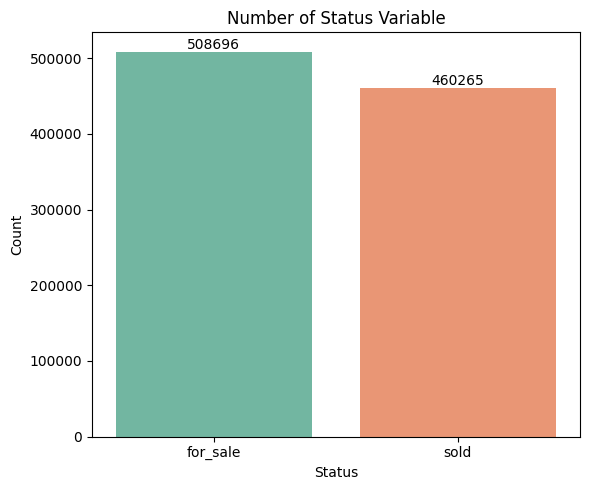

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choose a colorful palette
palette = sns.color_palette("Set2")  # Or try "pastel", "Set3", etc.

plt.figure(figsize=(6, 5))
ax = sns.countplot(data=df_process_pd, x='status', palette=palette)

# Adding text labels
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 0.5, int(height), ha='center', va='bottom')

# Titles and labels
ax.set_title("Number of Status Variable")
ax.set_xlabel("Status")
ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

**Bed_Bath - House Size Comparison**

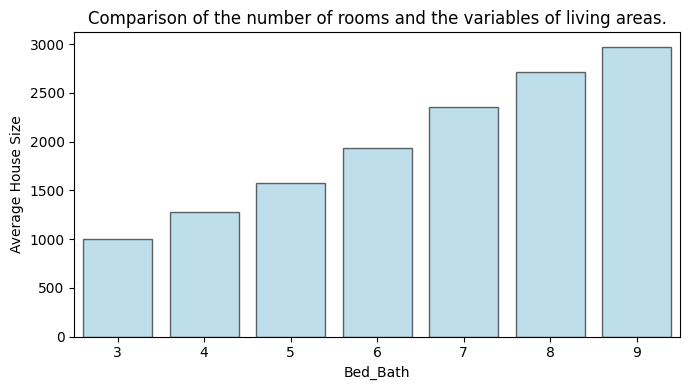

In [15]:
df_process_pd["bed_bath"] = df_process_pd["bed"] + df_process_pd["bath"]
df_grouped = df_process_pd.groupby("bed_bath")["house_size"].mean().reset_index()

df_grouped = df_grouped.sort_values(by="house_size", ascending=True)
plt.figure(figsize=(7, 4))

# Create the bar plot
sns.barplot(data=df_grouped, x="bed_bath", y="house_size",
            color='skyblue', edgecolor='black', alpha=0.6)

# Add title and labels
plt.title("Comparison of the number of rooms and the variables of living areas.")
plt.xlabel("Bed_Bath")
plt.ylabel("Average House Size")

# Show the plot
plt.tight_layout()
plt.show()

* The chart shows a strong positive relationship between the combined number of bedrooms-bathrooms and the average house size.
* In general, as the number of rooms increases, the living area also tends to increase.

**Bed_Bath - Price Comparison**

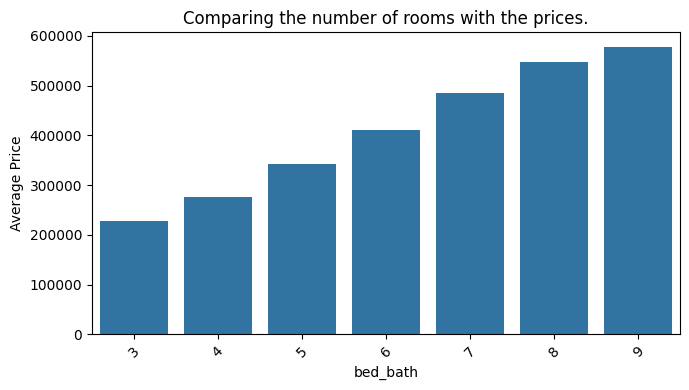

In [16]:
grouped_df = df_process_pd.groupby("bed_bath", as_index=False)["price"].mean()
grouped_df = grouped_df.sort_values("price", ascending=True)

# Plotting
plt.figure(figsize=(7, 4))  # width ~700px
sns.barplot(data=grouped_df, x='bed_bath', y='price', order=grouped_df['bed_bath'])

# Title and labels
plt.title("Comparing the number of rooms with the prices.")
plt.xlabel("bed_bath")
plt.ylabel("Average Price")

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* The bar chart clearly shows a positive correlation between the total number of rooms and the average house price.
* As Bed_Bath increases from 3 to 9, the average price steadily rises from around $230,000 to nearly $590,000.
* This reflects a typical market pattern: larger homes with more rooms tend to be more expensive due to increased space, amenities, and construction costs.

👉 The number of rooms (bed + bath) is a strong driver of housing price. Housing prices are strongly influenced by physical attributes such as house size, lot area, number of bedrooms, and number of bathrooms.

**State - House Size Comparison**

<ipython-input-17-ff7669025039>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


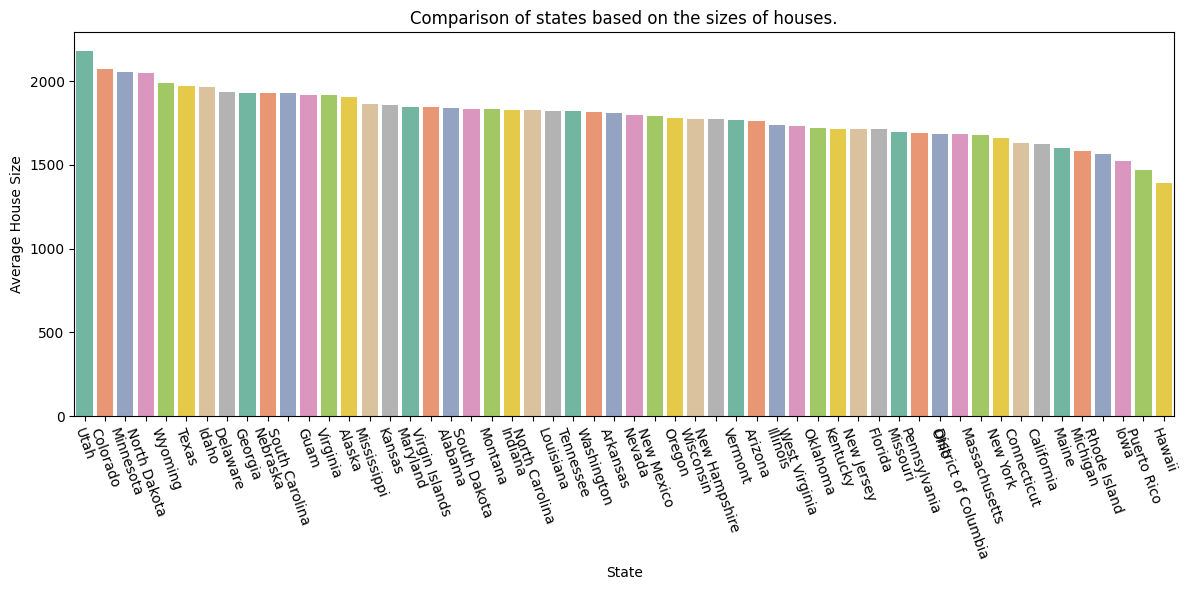

In [17]:
grouped_df = df_process_pd.groupby("state", as_index=False)["house_size"].mean()
grouped_df = grouped_df.sort_values("house_size", ascending=False)

# Generate a pastel color palette with as many colors as there are states
palette = sns.color_palette("Set2", len(grouped_df))

# Create a dictionary to map each state to a unique color
color_dict = dict(zip(grouped_df['state'], palette))

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(
    data=grouped_df,
    x='state',
    y='house_size',
    order=grouped_df['state'],
    palette=color_dict
)

# Title and labels
plt.title("Comparison of states based on the sizes of houses.")
plt.xlabel("State")
plt.ylabel("Average House Size")

# Rotate x-axis labels
plt.xticks(rotation=-70)
plt.tight_layout()
plt.show()

Significant regional disparities exist:

In the state of Ultah, it can be observed that the living areas of the listings are higher compared to other states, suggesting that houses in this state generally have spacious living areas.

In the state of Hawaii, it can be seen that the living areas of the listings are lowest compared to other states, suggesting that houses in this state generally is not too spacious.

**State - Price Comparison**

<ipython-input-18-43d116018041>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


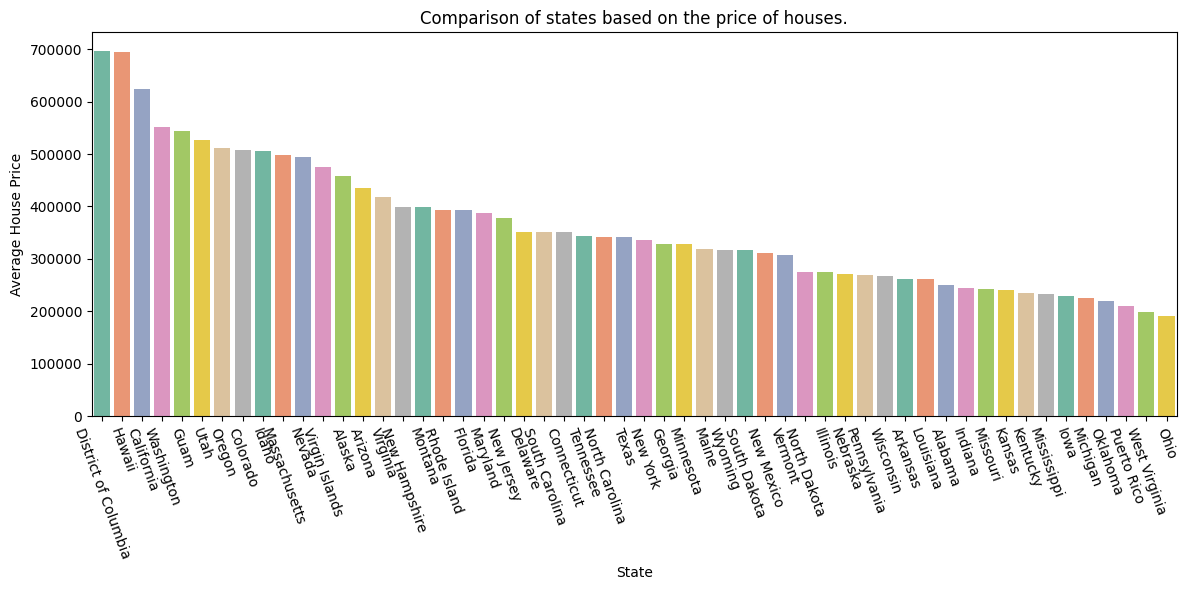

In [18]:
grouped_df = df_process_pd.groupby("state", as_index=False)["price"].mean()
grouped_df = grouped_df.sort_values("price", ascending=False)

# Generate a pastel color palette with as many colors as there are states
palette = sns.color_palette("Set2", len(grouped_df))

# Create a dictionary to map each state to a unique color
color_dict = dict(zip(grouped_df['state'], palette))

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(
    data=grouped_df,
    x='state',
    y='price',
    order=grouped_df['state'],
    palette=color_dict
)

# Title and labels
plt.title("Comparison of states based on the price of houses.")
plt.xlabel("State")
plt.ylabel("Average House Price")

# Rotate x-axis labels
plt.xticks(rotation=-70)
plt.tight_layout()
plt.show()

In the comparison between states and housing prices, average prices across states are presented. However, this does not imply that larger living spaces necessarily command higher prices.

The top three states with the highest average home prices are the District of Columbia, Hawaii, and California. Despite having relatively smaller land areas, these states maintain some of the highest housing prices in the country — **emphasizing the strong influence of location** over physical size.

**Price Distribution For Each State**

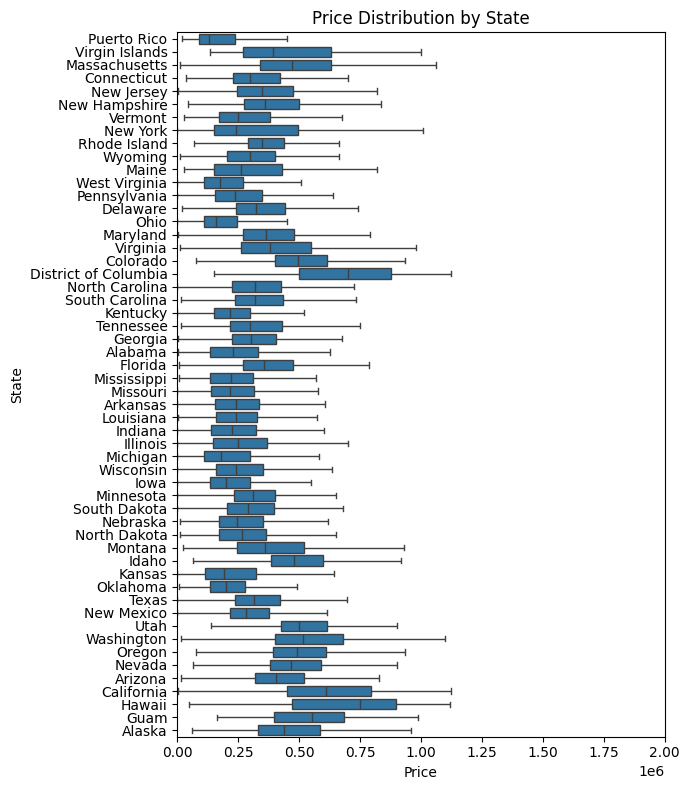

In [19]:
plt.figure(figsize=(7, 8))

sns.boxplot(data=df_process_pd, x="price", y="state", showfliers=False)
plt.xlim(0, 2_000_000)

# Title and axis labels
plt.title("Price Distribution by State")
plt.xlabel("Price")
plt.ylabel("State")

plt.tight_layout()
plt.show()

* District of Columbia, Hawaii, and California have the highest median house prices, indicating their markets are among the most expensive in the U.S.

* Puerto Rico, Mississippi, and West Virginia exhibit the lowest price medians, reflecting more affordable housing markets.

* Some states such as Alaska, Guam, and Hawaii show wide price ranges, suggesting greater price variability across properties — possibly due to differing regions (urban vs. rural) or property types.

* States such as Texas, Florida, and Arizona demonstrate moderate prices with broader variability, indicating a diverse housing market.

👉 The U.S. housing market shows significant regional variation in price, influenced by location, demand, urbanization, and economic conditions. Understanding state-level price distributions helps in:
* Identifying high-cost vs. affordable regions,
* Targeting investments geographically,
* Adjusting models for regional features in pricing predictions.

**City Proportions By The State**

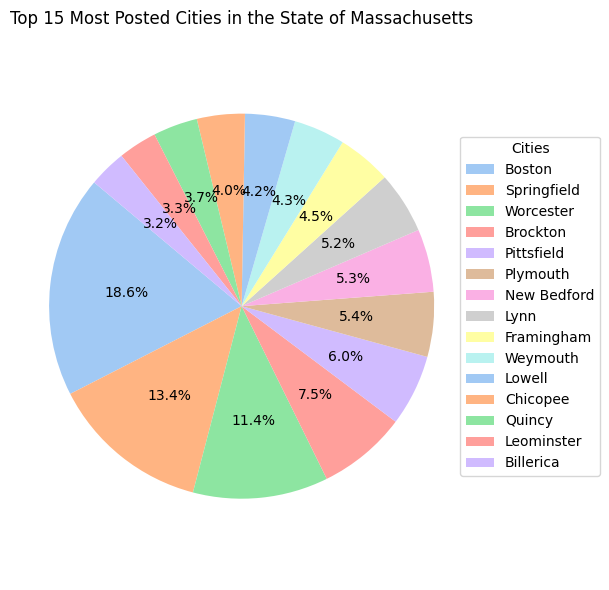

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

def show_cities_matplotlib(df, state, city_number=20):
    city_counts = df[df['state'] == state]['city'].value_counts().nlargest(city_number)

    colors = sns.color_palette('pastel', n_colors=city_number)

    plt.figure(figsize=(6, 6))
    wedges, texts, autotexts = plt.pie(
        city_counts.values,
        labels=None,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors
    )

    plt.legend(
        wedges,
        city_counts.index,
        title="Cities",
        loc="center left",
        bbox_to_anchor=(1, 0.5)
    )

    plt.title(f"Top {city_number} Most Posted Cities in the State of {state}")
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# Example usage
show_cities_matplotlib(df_process_pd, state='Massachusetts', city_number=15)

For example, in Massachusetts:
* Boston accounts for 18.6% of all listings, making it by far the most active market in the state.
* Springfield (13.4%) and Worcester (11.4%) follow, together comprising over 40% of listings.
* The distribution also suggests that while a handful of urban centers dominate the market, there is still a healthy breadth of activity across many smaller communities.

👉 Market focus for investors and agents should be on Boston, Springfield, and Worcester for volume—but opportunities also exist in the mid-tier cities.

👉 A long tail of smaller markets implies potential for niche strategies (e.g., targeting underserved suburban or rural areas).



**Grouped States, Price and Status of Sale Comparison**

The price of status (sold and for_sale) for each State are shown in the graph below:

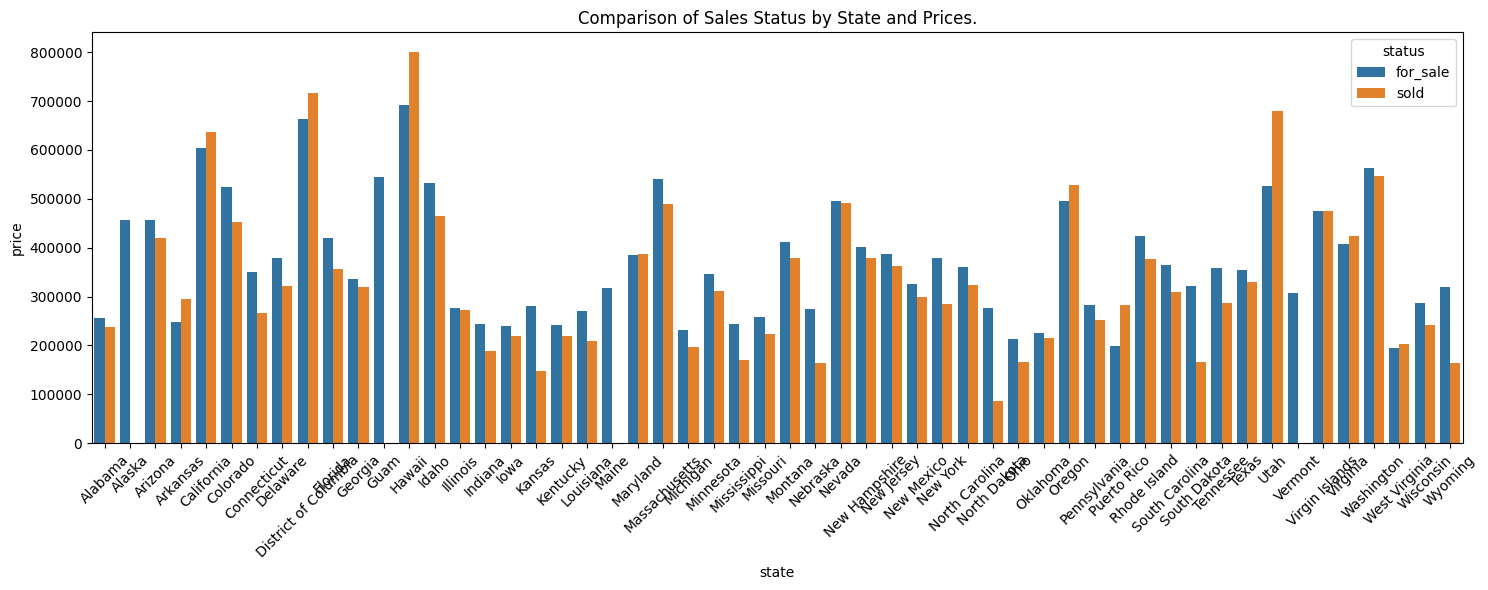

In [27]:
df_grouped = df_process_pd.groupby(["state", "status"])["price"].mean().reset_index()
plt.figure(figsize=(15, 6))
sns.barplot(data=df_grouped, x="state", y="price", hue="status")
plt.title("Comparison of Sales Status by State and Prices.")
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

Most U.S. states show a consistent gap between listed prices and actual sold prices
👉 possible bidding wars or seller pricing below market value to attract buyers.

Exceptions exist in some states where the for_sale price exceeds sold price
👉 overpricing or buyers negotiating prices down.

The discrepancy is most prominent in high-demand states such as California, Hawaii, and D.C., indicating strong market expectations that don’t always align with buyer behavior.

The comparison between listing and actual sale prices reveals market competitiveness and negotiation behavior:

* Higher sold than listed: Hot market, bidding activity.
* Lower sold than listed: Buyer resistance or overvaluation.
* Narrow gaps: Stable or well-priced markets.

**Data Correlation**

If we examine the correlation of the dataset, we can observe the rate of variation between variables.

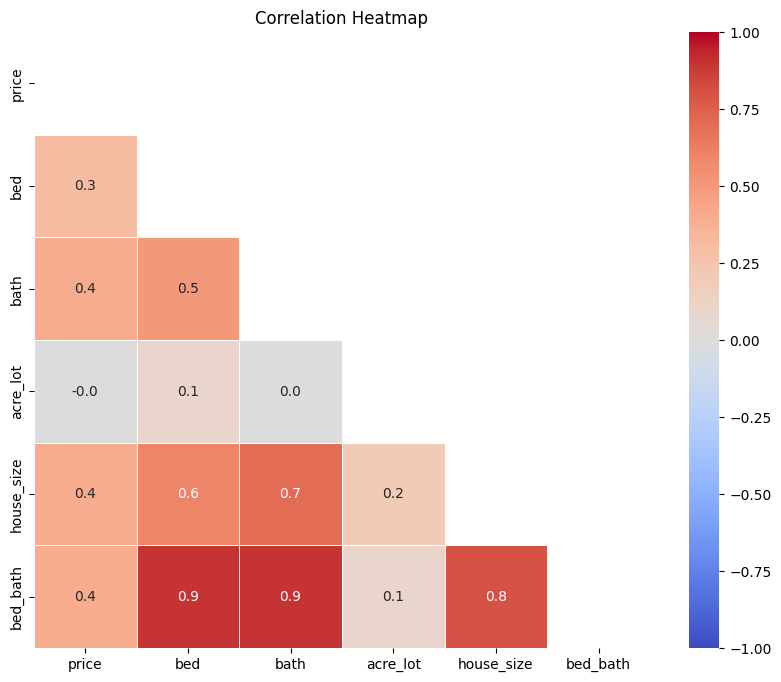

In [ ]:
numeric_cols = ['price', 'bed', 'bath', 'acre_lot', 'house_size','bed_bath']
df_corr = df_process_pd[numeric_cols]
df_corr = df_corr.corr().round(1)
mask = np.triu(np.ones_like(df_corr, dtype=bool))
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_corr, mask=mask, annot=True, cmap='coolwarm', fmt='.1f', vmin=-1, vmax=1, square=True, linewidths=0.5)

plt.title('Correlation Heatmap')
plt.show()

1. Correlation with price:
* bath (0.4) and house_size (0.4) show a moderate positive correlation with house prices → more bathrooms and larger houses tend to increase property value.

* bed (0.3) has a weaker positive correlation → the number of bedrooms impacts price, but less significantly.

* bed_bath (0.4) correlates similarly to bath and house_size → it can be a useful composite feature.

* acre_lot has a near-zero correlation with price (0.0) → lot size appears to have minimal influence on house value in this dataset.

2. Relationships between features: 
* bath and house_size: 0.7 & bed and bath: 0.5 → these features often increase together, reflecting common housing designs (more bedrooms & larger homes usually imply more bathrooms).


👉 Features like house_size, bath, and bed_bath have the strongest correlations with price → they are valuable for building prediction models.

👉 acre_lot contributes little explanatory power → location or other factors may outweigh land area in determining value.

# 3. Model Prediction

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In this section, we developed machine learning models (Linear Regression and Random Forest Regression) to predict housing prices based on features such as house size, lot size, number of bedrooms, and number of bathrooms.

In [ ]:
# Select features and target
feature_cols = ['bed', 'bath', 'acre_lot', 'house_size']
target_col = 'price'

# Prepare dataset
df_ml = df_process.select(feature_cols + [target_col]).dropna()
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_ml = assembler.transform(df_ml).select("features", target_col)

# Train-test split
train_df, test_df = df_ml.randomSplit([0.7, 0.3], seed=8889)

# Train Linear Regression
lr = LinearRegression(featuresCol="features", labelCol=target_col)
lr_model = lr.fit(train_df)
lr_preds = lr_model.transform(test_df)

# Train Random Forest Regression
rf = RandomForestRegressor(featuresCol="features", labelCol=target_col, numTrees=100)
rf_model = rf.fit(train_df)
rf_preds = rf_model.transform(test_df)

# Evaluate both models
evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="rmse")
lr_rmse = evaluator.evaluate(lr_preds)
rf_rmse = evaluator.evaluate(rf_preds)

evaluator_r2 = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="r2")
lr_r2 = evaluator_r2.evaluate(lr_preds)
rf_r2 = evaluator_r2.evaluate(rf_preds)

# Output
print(f"Linear Regression RMSE: {lr_rmse:.2f}, R²: {lr_r2:.2f}")
print(f"Random Forest RMSE: {rf_rmse:.2f}, R²: {rf_r2:.2f}")

Linear Regression RMSE: 190395.38, R²: 0.23
Random Forest RMSE: 189370.70, R²: 0.24


👉 The results show that Random Forest slightly outperforms Linear Regression in terms of accuracy, with lower error rates and higher R² scores.

In [ ]:
# Add predictions to DataFrames
lr_preds = lr_preds.withColumnRenamed("prediction", "lr_prediction")
rf_preds = rf_preds.withColumnRenamed("prediction", "rf_prediction")

# Join predictions on original features
combined_preds = lr_preds.select("features", "price", "lr_prediction") \
    .join(rf_preds.select("features", "rf_prediction"), on="features", how="inner")

# Show prediction table
combined_preds.select("price", "lr_prediction", "rf_prediction").show(10, truncate=False)

+--------+------------------+------------------+
|price   |lr_prediction     |rf_prediction     |
+--------+------------------+------------------+
|118000.0|194346.6300546726 |241500.41325955465|
|185000.0|216244.18185334973|241500.41325955465|
|185000.0|216244.18185334973|241500.41325955465|
|158000.0|216244.18185334973|241500.41325955465|
|158000.0|216244.18185334973|241500.41325955465|
|165000.0|227395.71286193532|241500.41325955465|
|29900.0 |230031.52928214642|241500.41325955465|
|29900.0 |230031.52928214642|241500.41325955465|
|29900.0 |230031.52928214642|241500.41325955465|
|29900.0 |230031.52928214642|241500.41325955465|
+--------+------------------+------------------+
only showing top 10 rows



The models provide a basic estimate of housing prices based on physical characteristics such as house size, number of rooms, and lot size. While they offer some insight into price trends, their predictive accuracy remains limited.

By comparing actual prices with predicted prices, we can identify cases of mispricing — for example, properties listed far above their expected value, or vice versa.

This demonstrates that, while the models have limited predictive power (R² = 0.24 & 0.23) in their current form, they still provide meaningful insights when analyzing historical housing data.

✅ Supporting homebuyers in making informed decisions,

✅ Helping investors identify undervalued opportunities, and

✅ Assisting lenders in evaluating collateral for loans.

However, the models still have limitations, given the model’s limited accuracy, these results should be interpreted with caution and ideally combined with additional market context. 

Future iterations could integrate geospatial data, time-based trends, and qualitative features to improve accuracy and applicability.

# Final Conclusion

The project presents a complete pipeline of real estate data analysis in the U.S., covering data preprocessing, exploratory analysis, and price prediction using machine learning models.

Exploratory analysis revealed:

✅ Strong price differences across states (e.g., D.C., California, Hawaii have highest prices)

✅ Moderate correlations between price and features like house size, number of bathrooms, and bedrooms

✅ Very weak correlation between price and lot size, indicating land area may not be a major determinant of property value

With the predictive models — Linear Regression and Random Forest — show limited predictive power, with R² values of approximately 0.23 and 0.24 respectively.

This suggests that while basic physical features such as house size, lot size, and room count carry some predictive value - not sufficient alone to fully explain housing prices. 

Future improvements should focus on feature enrichment (e.g., geographic, temporal, or neighborhood-based data) to enhance model performance and real-world applicability.